In [7]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import re
import cv2

from keras.models import Sequential
from keras.layers import Dense

import keras
from keras import losses
from keras.datasets import mnist
from keras.models import Sequential

from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras import backend as K
from keras.optimizers import Adam

from keras.models import model_from_json

In [53]:
# helper variables and functions for the submission
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch
patch_size = 16


def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0

    
# Convert array of labels to an image
def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im
            
            
def img_to_submission_strings(labels, img_number, w, h):
    """outputs the strings that should go into the submission file for a given image"""
    label_img = labels.reshape(w//patch_size,h//patch_size)
    for j in range(0, w, patch_size):
        for i in range(0, h, patch_size):
            label = label_img[i//patch_size][j//patch_size]
            if label > foreground_threshold:
                sub_lab = 1
            else:
                sub_lab = 0
                
            yield("{:03d}_{}_{},{}".format(img_number, j, i, sub_lab))

            
def reflectBorder(im) :
    bordersize = patch_size*2
    border=cv2.copyMakeBorder(im, top=bordersize, bottom=bordersize, left=bordersize, right=bordersize, borderType= cv2.BORDER_REFLECT )
    return border


def image_to_inputs(img, patch_size):
    rows, cols, _ = img.shape
    
    patches = [
        
            img[i-2*patch_size:i+3*patch_size, j-2*patch_size:j+3*patch_size, :]
        
        for j in range(2*patch_size, rows - 3*patch_size+1, patch_size)
        for i in range(2*patch_size, cols - 3*patch_size+1, patch_size)
    ]

    return patches


def disp_img_pred(img, pred):
    w = img.shape[0]
    h = img.shape[1]
    predicted_im = label_to_img(w, h, patch_size, patch_size, pred)
    cimg = concatenate_images(img, predicted_im)
    fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
    plt.imshow(cimg, cmap='Greys_r')
    new_img = make_img_overlay(img, predicted_im)
    plt.imshow(new_img)

    
# Concatenate an image and its predictions
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg


def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg


def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img


# creates submission file using a trained model and given images
def submission_with_model(model, submissionfilename):

    root_dir = "data/test_set_images/"
    
    # get filenames and images for all the 50 submission images
    image_dir = [root_dir + "test_{}/".format(i) for i in range(1, 51)]
    filenames = [fn for imdir in image_dir for fn in os.listdir(imdir)]
    images = [load_image(image_dir[i-1] + filenames[i-1]) for i in range(1, 51)]
    
    # reflect borders
    im_borders = [reflectBorder(im) for im in images]
    
    # get 16X16 patches of the images
    imgs_patched = [image_to_inputs(im, patch_size) for im in im_borders]
    
    # use model to predict, predictions are labels in a list of labels per image
    predictions = [model.predict(np.asarray(img_patched), verbose=1) for img_patched in imgs_patched]
    
    # Display prediction as an image
    disp_img_pred(images[0], predictions[0])
    
    with open(submissionfilename, 'w') as f:
        f.write('id,prediction\n')
        for nr in range(1, 51):
            f.writelines('{}\n'.format(s) for s in img_to_submission_strings(predictions[nr-1], nr, images[nr-1].shape[1], images[nr-1].shape[0]))

    

In [5]:
# load the model from data
path = 'savedModels/'
fm = open(path + 'model_2')
model = model_from_json(fm.read())
fm.close()

model.load_weights(path + 'weights_2', by_name=False)

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-3),#'rmsprop',
              metrics=['accuracy'])


1440/1444 [============================>.] - ETA: 0s

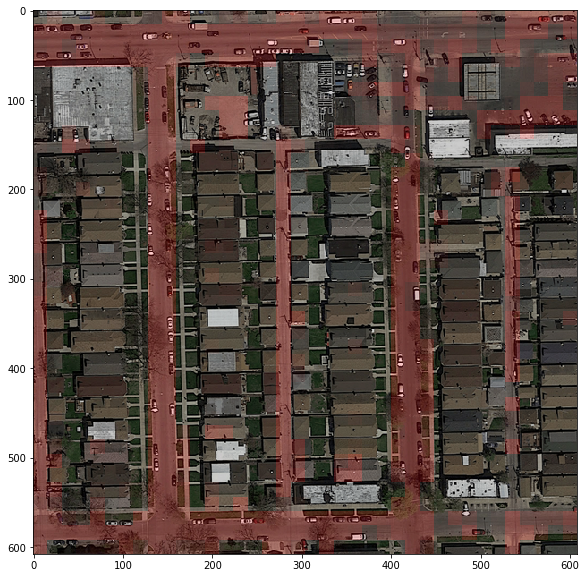

In [54]:
submission_with_model(model, 'submission_test_1.csv')